# in this notebook we will run some exepriements to figure out what the benchmark design should be.

## Experiment 1: what context to include
We have filtered the dataset into documents that work with wgpu (at least naga), are permissively licenses, and extract functions that contain both a comment directly before as well as a docstring directly at the top of the function body.
we compare the four scenarios:
- comment + header
- comment + header + docstring (both)
- header + docstring
- header (none)
it's 4x150 generations. We will use deepseek-coder (1.3b or 6.7b) as that showed promising signs before.

This notebook will just run generations - the postprocessing might be done externally (like here? https://github.com/Vipitis/bigcode-evaluation-harness/tree/shadereval)
or we throw something together tomorrow.

In [3]:
!pip install datasets

^C


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, StopStringCriteria
from accelerate import Accelerator
from datasets import load_dataset
from torch import bfloat16
import json

from tqdm.auto import tqdm

accelerator = Accelerator()
device = accelerator.device
print(device)

experiment_ds = load_dataset("Vipitis/Shadereval-experiments-dev")# , download_mode="force_redownload")
experiment_ds = experiment_ds["train"] if "train" in experiment_ds else experiment_ds #unpack if DatasetDict?
model_id = "deepseek-ai/deepseek-coder-6.7b-base"
# model_id = "deepseek-ai/deepseek-coder-1.3b-base"
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=bfloat16, low_cpu_mem_usage=True).to(device) # this option works on free colab!
tokenizer = AutoTokenizer.from_pretrained(model_id)
stop_words = ["\nfloat", "\nvec", "\nint", "\nmat"] # should cover the really common cases to speed things up.

pipe = pipeline("text-generation", model=model, tokenizer=model_id, do_sample=False, stop_strings=stop_words, return_full_text=False, max_new_tokens=512, num_return_sequences=1, torch_dtype='bfloat16', device=device)

ImportError: cannot import name 'StopStringCriteria' from 'transformers' (c:\Users\Jan\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\__init__.py)

In [ ]:
# alternative variant where we use the pipeline as an iterator
from transformers.pipelines.pt_utils import KeyDataset
import json

gens = {}
for experiment in tqdm(["input_both", "input_comment", "input_docstring", "input_none"]): # need to just run input_none again!
    exp_gens = []
    for out in tqdm(pipe(KeyDataset(experiment_ds, experiment), tokenizer=tokenizer, max_new_tokens=512, num_return_sequences=1)):
        exp_gens.append(out[0]["generated_text"]) #check if the access here is correct before running it.
    with open(f"exp1_v02_{len(experiment_ds)}_{experiment}.json", "w", encoding="utf-8") as outfile:
        json.dump({experiment:exp_gens}, outfile)

with open(f"exp1_gens_{len(experiment_ds)}_.json", "w", encoding="utf-8") as outfile2:
    json.dump(gens, outfile2)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

In [ ]:
# tiny script to assemble intermediate results (not to be rerun) change this after the above fixes have been made.
import json

experiments = ["input_docstring-67b", "input_docstring", "input_both-67b", "input_both", "input_comment-67b", "input_comment", "input_none-67b", "input_none"]
all_runs = {}
for exp in experiments:
    print(exp)
    if exp in ("input_none", "input_both-67b", "input_comment-67b", "input_docstring-67b", "input_none-67b", ): # this is the correct way, but we have them standalone a bit.
        with open(f"exp1_v02_257_{exp}.json", "r", encoding="utf-8") as infile:
            run = json.load(infile)
            all_runs[exp] = run[exp.split("-")[0]]
        continue
    # TODO: just save these files correctly and have a simple loading script.
    with open(f"exp1_v02_257_{exp}.json", "r", encoding="utf-8") as infile:
        run = json.load(infile)
        # print(len(run[exp]))
        all_runs[exp] = [x[0]["generated_text"] for x in run[exp]]

with open(f"exp1_gens_257_13plus67.json", "w", encoding="utf-8") as outfile:
    json.dump(all_runs, outfile)

input_docstring-67b
input_docstring
input_both-67b
input_both
input_comment-67b
input_comment
input_none-67b
input_none


In [4]:
# load_generations and references
import json
from datasets import load_dataset

experiment_ds = load_dataset("Vipitis/Shadereval-experiments-dev")# , download_mode="force_redownload")
df = experiment_ds["train"].to_pandas()

# gen_file = "exp1_generations_0-150.json" #old 150 clue
# gen_file = "exp1_gens_257_NO4.json" #new 275 run, but missing input_none run
# gen_file = "exp1_gens_257_13plusTWO.json" # this now includes one run with the larger model... maybe we can do them in parallel?
gen_file = "exp1_gens_257_13plus67.json" # now we include runs fore 1.3 and 6.7 at max_tokens=512 for both!

with open(gen_file, "r", encoding="utf-8") as infile:
    generations = json.load(infile)

# change the order of keys to be "docstrings, both, comment, none"
# generations = {k:generations[k] for k in ["input_docstring-67b", "input_docstring", "input_both-67b", "input_both", "input_comment-67b", "input_comment", "input_none"]}

In [5]:
# hack imports
import sys
import os

# Add the parent directory to sys.path
print(sys.path)
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.path.abspath('')), '.')))
print(sys.path)

['c:\\Users\\Jan\\Documents\\uni_online\\SoSe2024\\shadertoys-dataset\\experiments', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\DLLs', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39', '', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\Pythonwin', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\setuptools\\_vendor']
['c:\\Users\\Jan\\Documents\\uni_online\\SoSe2024\\shadertoys-dataset\\experiments', 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'c:\\Users\\Jan\

In [6]:
# step 1. parse for valid function in (input+generation)
from annotate import parse_functions

for k,v in generations.items():
    df[f"gen_{k}"] = v

In [7]:
# step 2 clean up and insert the generations into the code as alternatives.

def truncate_function(model_inp, model_pred):
    combined = model_inp + model_pred
    functions = parse_functions(combined)
    if functions == []:
        return model_pred + "// incomplete generation! \n"
    # print(f"{len(functions)} functions found: {functions}")
    num_bytes_inp = len(bytes(model_inp, encoding="utf-8"))
    first_function = functions[0]
    end_first_function = first_function[4]
    cleaned_pred = bytes(model_pred, encoding="utf-8")[:end_first_function-num_bytes_inp]
    return cleaned_pred.decode(encoding="utf-8")

def replace_body(row, altered_body):
    start_comment, start_header, end_header, end_docstring, end_function = row["func_bytes"]
    full_code = bytes(row["full_code"], encoding="utf-8")
    altered_body_bytes = bytes(altered_body, encoding="utf-8")
    altered_code = full_code[:end_docstring] + altered_body_bytes + full_code[end_function:] #might miss the docstring at times...
    return altered_code.decode(encoding="utf-8")

In [8]:

for k in generations.keys():
    df[f"gen_{k}_truncated"] = df.apply(lambda x: truncate_function(x[k.split("-")[0]], x[f"gen_{k}"]), axis=1)

for k in generations.keys():
    df[f"{k}_altered"] = df.apply(lambda x: replace_body(x, x[f"gen_{k}_truncated"]), axis=1)

df.head()

,id,comment,header,docstring,body,full_code,func_bytes,has_comment,has_docstring,model_ctx,...,gen_input_none-67b_truncated,gen_input_none_truncated,input_docstring-67b_altered,input_docstring_altered,input_both-67b_altered,input_both_altered,input_comment-67b_altered,input_comment_altered,input_none-67b_altered,input_none_altered
0,4slXD7,"//vec3 i = vec3(.5)+vec3(.5,-.5,-.5);\n//=> fc...",float fcos( float a )\n{,"\n\t//return max(0.0,(cos( a )+.5)/1.5);","\n\treturn pow( cos(a)*.5+.5, 2.0 );\n}","// this looks prettier, but makes it less obvi...","[163, 346, 369, 407, 443]",True,True,"//vec3 i = vec3(.5)+vec3(.5,-.5,-.5);\n//=> fc...",...,\n\tfloat a2 = a * a;\n\tfloat a4 = a2 * a2;\n...,\n\treturn cosf( a );\n},"// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi...","// this looks prettier, but makes it less obvi..."
1,4dSXDd,// This is the big money function that makes t...,float DistanceToObject(vec3 p)\n{,"\n //p += (1.0/p.y)*0.6;\n\n // Rotate, ...","\n if (dot(p, rotDir) > 1.0) p *= rotMat;\n...",/*--------------------------------------------...,"[4341, 4412, 4444, 4534, 6672]",True,True,// This is the big money function that makes t...,...,"\n float d = sdSphere(p, 1.0);\n d = opS...",\n float d = length(p - _position);\n re...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...,/*--------------------------------------------...
2,MlfGR4,// Distance to the voxel\n,float distVoxel (in vec3 p) {,\n\n\t// Update the glow counter,\n\t++glowCounter;\n\n\t// Rounded box\n\tcons...,//////////////////////////////////////////////...,"[1606, 1631, 1660, 1689, 1828]",True,True,// Distance to the voxel\nfloat distVoxel (in ...,...,\n float d = length(p) - 1.0;\n return d...,\n vec3 q = p - voxelPos;\n return lengt...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...
3,MlfGR4,// Distance to the scene and color of the clos...,"vec2 distScene (in vec3 p, out vec3 P) {",\n\n\t// Update the glow counter,\n\t++glowCounter;\n\n\t// Scaling\n\tp *= VOX...,//////////////////////////////////////////////...,"[1830, 1886, 1926, 1955, 3611]",True,True,// Distance to the scene and color of the clos...,...,\n vec3 q = p;\n float d = length(q) - 1...,"\n vec3 P0 = vec3(0.0, 0.0, 0.0);\n vec3...",//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...,//////////////////////////////////////////////...
4,MlfGR4,// Main function\n,"void mainImage (out vec4 fragColor, in vec2 fr...",\n\n\t// Get the fragment,\n\tvec2 frag = (2.0 * fragCoord.xy - iResolut...,//////////////////////////////////////////////...,"[5899, 5916, 5972, 5994, 9538]",True,True,// Main function\nvoid mainImage (out vec4 fra...,...,\n vec2 uv = fragCoord.xy / iResolution.xy;...,\n vec2 uv = fragCoord.xy / iResolution.xy;...,///////////////////////////////

In [9]:
# simple lexer via tree-sitter?

# simple lexer?
import tree_sitter

def get_leaves(subtree: tree_sitter.Node, skip_comments: bool=False, rename_identifiers: bool=False) -> list[str]:
    # TODO: add like a wrapper function to give the root node initially...
    tokens = []
    if subtree.child_count == 0:
        if subtree.type == "comment" and skip_comments:
            pass
        elif subtree.type == "identifier" and rename_identifiers:
            # TODO: what about different name spaces - where do we hand this upwards?
            # do we need to like return our mapping to get different placeholders?
            return [f"id"]
        else:
            return [subtree.text]
    else:
        for child in subtree.children:
            tokens.extend(get_leaves(child, skip_comments, rename_identifiers))
    return tokens

# exact_tokens = get_leaves(tree.root_node, skip_comments=False)
# lexical_tokens = get_leaves(tree.root_node, skip_comments=True)
# syntax_tokens = get_leaves(tree.root_node, True, True)
# print(len(exact_tokens))
# print(len(lexical_tokens))
# print(len(syntax_tokens))

# tree.root_node.children[3].children[1].children[0].text
# syntax_tokens

In [10]:
import evaluate

shadermatch = evaluate.load("../../Thesis/shadermatch") # try loading locally

# evaluate the altered code
# res = shadermatch.compute(references=df["full_code"].tolist(), predictions=df["input_comment_altered"].tolist())
# res



In [11]:
# takes 64 seconds on laptop, now 40 seconds it seems.
# step 3. run evaluations!

from annotate import run_shader, PARSER
from wgpu_shadertoy import Shadertoy
from PIL import Image
import numpy as np
RESOLUTION = (512, 288) # same as thumbnail, should do for now.

def compare_shaders(reference, prediction):
    if reference == prediction:
        return "c0-clone" #exact match
    if "// incomplete generation! \n" in prediction:
        return "incomplete_generation" # ususally the a loop
    ref_tree = PARSER.parse(bytes(reference, encoding="utf-8"))
    pred_tree = PARSER.parse(bytes(prediction, encoding="utf-8"))
    ref_lex_tokens = get_leaves(ref_tree.root_node, True)
    pred_lex_tokens = get_leaves(pred_tree.root_node, True)
    if ref_lex_tokens == pred_lex_tokens:
        return "c1-clone" #lexical similarity: differences in comments and white spaces only
    ref_syn_tokens = get_leaves(ref_tree.root_node, True, True)
    pred_syn_tokens = get_leaves(pred_tree.root_node, True, True)
    if ref_syn_tokens == pred_syn_tokens:
        return "c2-clone*" #almost syntactic similarity. our identifier replacement isn't perfect yet
    else:
        try:
            pred_shader = Shadertoy(prediction, shader_type="glsl", resolution=RESOLUTION, offscreen=True)
            ref_shader = Shadertoy(reference, shader_type="glsl", resolution=RESOLUTION, offscreen=True)
            pred_frame_data = pred_shader.snapshot(123.456)
            ref_frame_data = ref_shader.snapshot(123.456)
        except Exception as e:
            return "code_error"
        pred_frame = Image.fromarray(np.asarray(pred_frame_data)[..., [2, 1, 0, 3]]).convert('RGB')
        ref_frame = Image.fromarray(np.asarray(ref_frame_data)[..., [2, 1, 0, 3]]).convert('RGB')
        if pred_frame == ref_frame:
            return "c4-clone" #same image essentially? maybe needs a numpy comparison
        elif pred_frame.getcolors(1) is not None:
            return "single_color" #all the same color indicates a "lame variation, silent bug"
        else:
            return "variation" # the remainder.

    # else:
    #     return "other"


def run_comparison(row, k):
    # print(row["id"])
    # hotpatch this to get numbers
    if row["id"] in ("4tGGzd", "tdyyzc"): # we got more now...
        return "skipped"
        # pass #try if they still stall
    ref = row["full_code"]
    pred = row[f"{k}_altered"]
    return compare_shaders(ref, pred)

for k in generations.keys():
    df[f"{k}_comp"] = df.apply(run_comparison, axis=1,k=k)
    print(df[f"{k}_comp"].value_counts())

Expected wgpu-native version (22, 1, 0) but got (0, 0, 0). You may need to run download-wgpu-native.py (in the root of the repo).
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [33]
  │ 
  │ naga::Function [6]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [105]
  │ naga::Expression [106]
  │ naga::Function [1]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [61]
  │ naga::Expression [62]
  │ naga::Function [13]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [33]
  │ naga::Expression [34]
  │ naga::Function [1]


Returning Some(Vector { size: Quad, scalar: Scalar { kind: Float, width: 4 } }) where Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) is expecte

incomplete_generation    125
variation                 70
code_error                34
c4-clone                  13
single_color              10
skipped                    3
c1-clone                   2
Name: input_docstring-67b_comp, dtype: int64


Returning Some(Scalar(Scalar { kind: Float, width: 4 })) where Some(Vector { size: Bi, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Function [6]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [42]
  │ naga::Expression [32]
  │ naga::Function [4]


Returning Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) where Some(Scalar(Scalar { kind: Float, width: 4 })) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [61]
  │ 
  │ naga::Function [5]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [838]
  │ 
  │ naga::Function [4]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   

incomplete_generation    142
code_error                52
variation                 46
single_color               8
c4-clone                   6
skipped                    3
Name: input_docstring_comp, dtype: int64


Returning Some(Scalar(Scalar { kind: Float, width: 4 })) where Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [11]
  │ 
  │ naga::Function [10]


Returning None where Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Function [2]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [33]
  │ naga::Expression [34]
  │ naga::Function [1]




incomplete_generation    113
code_error                60
variation                 57
c4-clone                  12
single_color               8
skipped                    3
c1-clone                   3
c2-clone*                  1
Name: input_both-67b_comp, dtype: int64


Returning Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) where Some(Vector { size: Bi, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [64]
  │ 
  │ naga::Function [2]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [60]
  │ 
  │ naga::Function [3]


Returning Some(Vector { size: Quad, scalar: Scalar { kind: Float, width: 4 } }) where Some(Struct { members: [StructMember { name: Some("diffuse"), ty: [1], binding: None, offset: 0 }, StructMember { name: Some("specular"), ty: [1], binding: None, offset: 16 }, StructMember { name: Some("metallic"), ty: [2], binding: None, offset: 28 }, StructMember { name: Some("roughness"), ty: [2], binding: None, offset: 32 }], span: 48 }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
 

incomplete_generation    126
variation                 68
code_error                46
c4-clone                   8
single_color               5
skipped                    3
c1-clone                   1
Name: input_both_comp, dtype: int64


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [90]
  │ 
  │ naga::Function [1]


Returning Some(Scalar(Scalar { kind: Float, width: 4 })) where Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [11]
  │ 
  │ naga::Function [10]


Returning Some(Scalar(Scalar { kind: Float, width: 4 })) where Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [11]
  │ 
  │ naga::Function [2]


Returning Some(Scalar(Scalar { kind: Float, width: 4 })) where Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::E

variation                93
incomplete_generation    77
code_error               56
c4-clone                 13
single_color             13
skipped                   3
c0-clone                  1
c1-clone                  1
Name: input_comment-67b_comp, dtype: int64


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [51]
  │ 
  │ naga::Function [0]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [74]
  │ 
  │ naga::Function [3]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [17]
  │ 
  │ naga::Function [48]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [45]
  │ naga::Expression [46]
  │ naga::Function [13]




variation                94
incomplete_generation    72
code_error               57
single_color             19
c4-clone                 10
skipped                   3
c2-clone*                 2
Name: input_comment_comp, dtype: int64


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [57]
  │ 
  │ naga::Function [1]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [45]
  │ naga::Expression [46]
  │ naga::Function [13]




variation                119
incomplete_generation     56
code_error                56
c4-clone                  13
single_color              10
skipped                    3
Name: input_none-67b_comp, dtype: int64


Returning Some(Vector { size: Tri, scalar: Scalar { kind: Float, width: 4 } }) where Some(Vector { size: Bi, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [15]
  │ 
  │ naga::Function [7]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [34]
  │ naga::Expression [35]
  │ naga::Function [8]


Returning Some(Scalar(Scalar { kind: Float, width: 4 })) where Some(Vector { size: Bi, scalar: Scalar { kind: Float, width: 4 } }) is expected
Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Expression [33]
  │ 
  │ naga::Function [23]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │  
  │ 
  │ naga::Expression [18]
  │ naga::Expression [19]
  │ naga::Function [2]


Device::create_shad

variation                84
code_error               81
incomplete_generation    60
single_color             19
c4-clone                 10
skipped                   3
Name: input_none_comp, dtype: int64


c:\Users\Jan\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


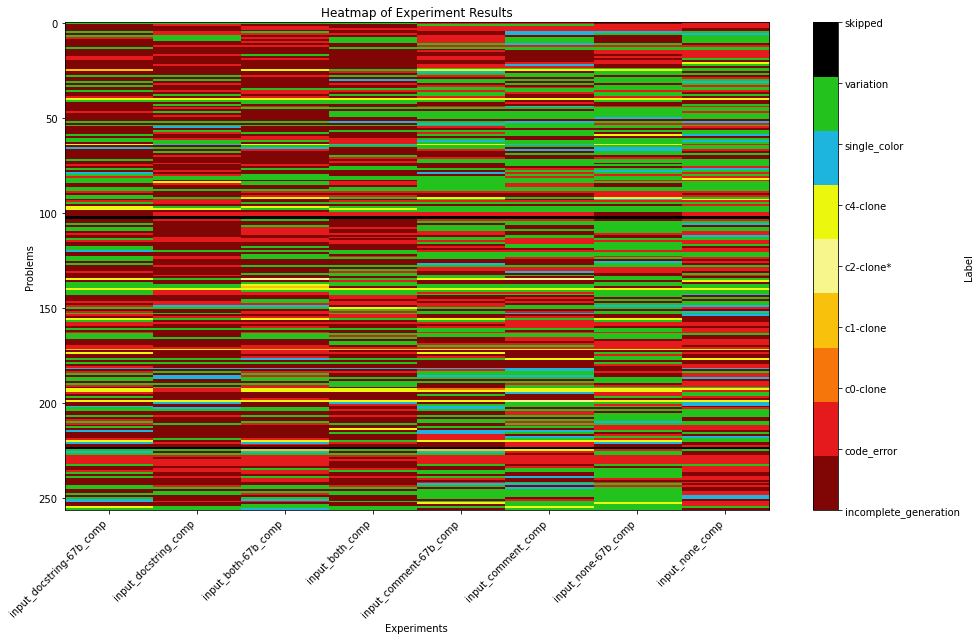

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# mapping labels to ids and give givng them an order
label_mapping = {
    'incomplete_generation': 0.0,
    'code_error': 1.0,
    'c0-clone': 2.0,
    'c1-clone': 3.0,
    'c2-clone*': 4.0,
    'c4-clone': 5.0,
    'single_color': 6.0,
    'variation': 7.0,
    'skipped': 8.0,
}

color_range = [
    "#800505", # incomplete_generation
    "#e41a1c", # code_error
    "#f7760c", # c0-clone
    "#f7c10c", # c1-clone
    "#f6f68c", # c2-clone
    "#ebf70c", # c4-clone
    "#1db4de", # single_color
    "#23c21d", # variation
    "#000000", # skipped
]

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', color_range, N=len(color_range))

# Assuming `generations` and `df` are already defined
cols = [f"{k}_comp" for k in generations.keys()]
label_df = df[cols]
label_df.replace(label_mapping, inplace=True)
# label_df = label_df.sort_values(by=cols[5], ascending=False) #sort by comment column
label_arr = label_df.to_numpy()

# Plot the heatmap
plt.figure(figsize=(14, 9))
plt.imshow(label_arr, aspect='auto', interpolation='nearest', cmap=custom_cmap)

# Set x-tick labels
plt.xticks(ticks=np.arange(len(cols)), labels=cols, rotation=45, ha='right')

# Create a color bar with custom ticks and labels
cbar = plt.colorbar()
cbar.set_ticks(list(label_mapping.values()))
cbar.set_ticklabels(list(label_mapping.keys()))
cbar.set_label('Label')

# Set labels and title
plt.xlabel('Experiments')
plt.ylabel('Problems')
plt.title('Heatmap of Experiment Results')

# Show the plot
plt.tight_layout()
# plt.savefig("heatmap.png")
plt.show()

In [13]:
import pandas as pd
cols = [f"{k}_comp" for k in generations.keys()]
scores = df[cols]
# value counts per column
num_rows = len(scores) - 3 #3 is hard coded number of skips right now.
scores = scores.apply(pd.Series.value_counts, axis=0)
scores = scores/num_rows # get rates instead of counts
scores = scores.fillna(0)
scores = scores.T
scores["error_rate"] = scores["code_error"] + scores["incomplete_generation"]
# scores["clone_rate"] = scores["c0-clone"] + scores["c1-clone"] + scores["c2-clone*"] + scores["c4-clone"]
# scores.sort_values(by="error_rate", ascending=False, inplace=True)
# remove "_comp" from the row names
scores.index = scores.index.str.replace("_comp", "")
# add a miltiindex for model.
scores.index = pd.MultiIndex.from_tuples([(x.split("-")[0], "6.7b") if "-" in x else (x, "1.3b") for x in scores.index], names=["experiment", "model"])
# scores.plot(kind="bar", stacked=True, figsize=(12, 6), colormap=custom_cmap)

# remove skipped column
scores = scores.drop("skipped", axis=1)

scores = scores.T # transpose back

scores.to_latex("scores.tex", float_format="{:.3f}".format)
scores


experiment            input_docstring           input_both            \
model                            6.7b      1.3b       6.7b      1.3b   
c0-clone                     0.000000  0.000000   0.000000  0.000000   
c1-clone                     0.007874  0.000000   0.011811  0.003937   
c2-clone*                    0.000000  0.000000   0.003937  0.000000   
c4-clone                     0.051181  0.023622   0.047244  0.031496   
code_error                   0.133858  0.204724   0.236220  0.181102   
incomplete_generation        0.492126  0.559055   0.444882  0.496063   
single_color                 0.039370  0.031496   0.031496  0.019685   
variation                    0.275591  0.181102   0.224409  0.267717   
error_rate                   0.625984  0.763780   0.681102  0.677165   

experiment            input_comment           input_none            
model                          6.7b      1.3b       6.7b      1.3b  
c0-clone                   0.003937  0.000000   0.000000  0.000000  
c1-clone                   0.003937  0.000000   0.000000  0.000000  
c2-clone*                  0.000000  0.007874   0.000000  0.000000  
c4-clone                   0.051181  0.039370   0.051181  0.039370  
code_error                 0.220472  0.224409   0.220472  0.318898  
incomplete_generation      0.303150  0.283465   0.220472  0.236220  
single_color               0.051181  0.074803   0.039370  0.074803  
variation                  0.366142  0.370079   0.468504  0.330709  
error_rate                 0.523622  0.507874   0.440945  0.555118

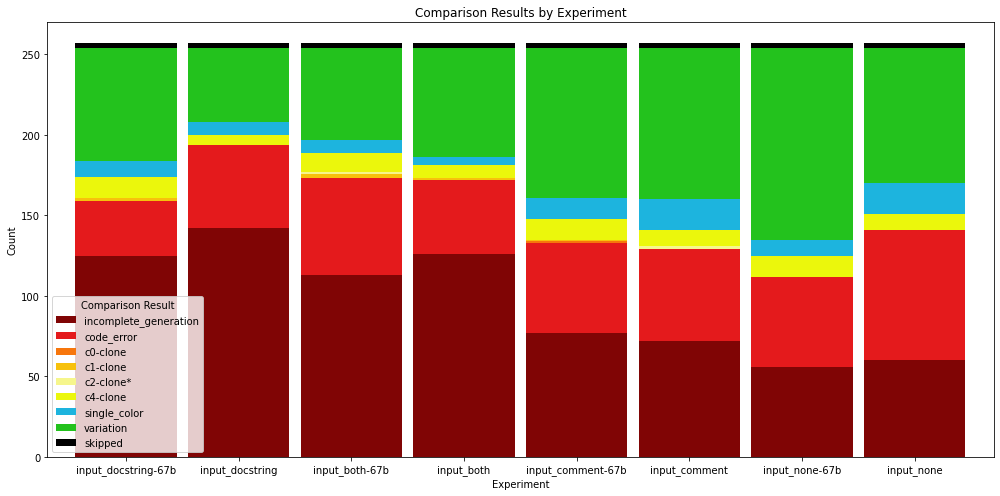

In [14]:
#all columns are sorted here, gives a better overview.

# via copilot but looks great
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Aggregate the comparison results
# Assuming 'df' is your DataFrame and 'generations.keys()' contains the experiment identifiers
comparison_results = {}
for k in generations.keys():
    comparison_results[k] = df[f"{k}_comp"].value_counts()


# Step 2: Transform the data for plotting
# Convert the dictionary to a DataFrame for easier plotting
comparison_df = pd.DataFrame(comparison_results).fillna(0).T

# use labels and order from above
comparison_df = comparison_df.reindex(columns=list(label_mapping.keys()))
# Step 3: Plot the data using the colors from above
comparison_df.plot(kind='bar', width=0.9, stacked=True, figsize=(14, 7), color=color_range)
plt.title('Comparison Results by Experiment')
plt.xlabel('Experiment')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.legend(title='Comparison Result')
plt.tight_layout()
plt.savefig("../../Thesis/report/texs/charts/input_experiments.png") # save directly into my thesis folder
plt.show()

In [29]:
# maybe spot some kind of pattern
# 0 incomplete_generation, 1 code_error
df[label_df["input_comment-67b_comp"] <= 1][["comment", "header"]]


,comment,header
0,"//vec3 i = vec3(.5)+vec3(.5,-.5,-.5);\n//=> fc...",float fcos( float a )\n{
2,// Distance to the voxel\n,float distVoxel (in vec3 p) {
3,// Distance to the scene and color of the clos...,"vec2 distScene (in vec3 p, out vec3 P) {"
4,// Main function\n,"void mainImage (out vec4 fragColor, in vec2 fr..."
5,// color gradient \n// this should be in a 1D ...,vec4 gradient(float x)\n{
...,...,...
242,// 3D Raymarching\n,"vec3 raymarch(vec3 raydir, vec3 rayori){"
245,// -------------------------------------------...,"void mainImage( out vec4 fragColor, in vec2 fr..."
251,//////////////////////////////////////////////...,"void mainImage( out vec4 fragColor, in vec2 fr..."
254,"// License: MIT, author: Inigo Quilez, found: ...","vec3 postProcess(vec3 col, vec2 q) {"


In [16]:
df["header"].value_counts()

void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    13
vec2 hash22(vec2 p) {                                          5
float noise3D(vec3 p){                                         3
v2 c(v1 U){                                                    3
void mainImage(out vec4 fragColor, in vec2 fragCoord){         3
                                                              ..
float vormod(float f){                                         1
vec3 EnChromaRgb(vec3 c){                                      1
vec4 sdBoxCheap(DAVec3 p,vec3 s){                              1
vec4 sdSuperprim(DAVec3 p, i4 s,vec2 r) {                      1
float cubeSDF(vec3 p) {                                        1
Name: header, Length: 221, dtype: int64

https://shadertoy.com/view/llsSzB
void mainImage( out vec4 fragColor, in vec2 fragCoord )
{


<module 'matplotlib.pyplot' from 'c:\\Users\\Jan\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

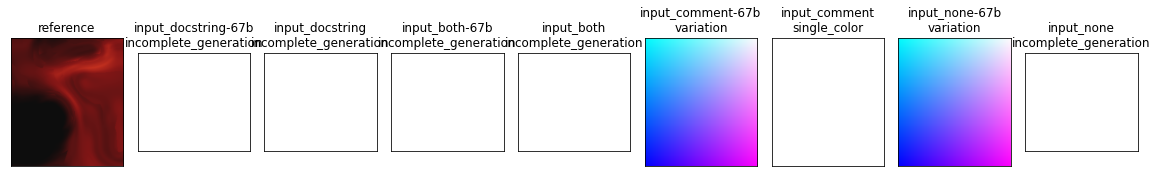

In [17]:
# parallel comparison of the images

render_res = (212,242)

def plot_comparison(row_idx, time_sample=12.3456):
	print(f"https://shadertoy.com/view/{df.iloc[row_idx]['id']}")
	print(f"{df.iloc[row_idx]['header']}")
	if row_idx == 102 or row_idx == 103:
		print("these should be skipped!!")
		row_idx = 0

	plt.figure(figsize=(16, 5), label=f"row {row_idx}")
	num_plots = len(generations)+1
	plt.subplot(1, num_plots, 1)

	ref = df["full_code"].iloc[row_idx]
	ref_shader = Shadertoy(ref, shader_type="glsl", resolution=render_res, offscreen=True)
	ref_frame_data = ref_shader.snapshot(time_sample)
	ref_frame = Image.fromarray(np.asarray(ref_frame_data)[..., [2, 1, 0, 3]].copy()).convert('RGB')
	plt.imshow(ref_frame)
	plt.title("reference")
	plt.xticks([])
	plt.yticks([])
	for idx, exp in enumerate(generations.keys()):
		# print(idx)
		plt.subplot(1, num_plots, idx+2)
		comp_label = df[f"{exp}_comp"].iloc[row_idx]
		# print(comp_label)
		if comp_label in ("code_error", "skipped", "incomplete_generation", "c0-clone", "c1-clone", "c2-clone*", "c4-clone"):        
			# add a placeholder subplot in these cases
			plt.title(f"{exp}\n{comp_label}")
			plt.imshow(np.ones(shape=render_res + (3,)))
			plt.xticks([])
			plt.yticks([])
			continue
		pred = df[f"{exp}_altered"].iloc[row_idx]
		try:
			pred_shader = Shadertoy(pred, shader_type="glsl", resolution=render_res, offscreen=True)
			pred_frame_data = pred_shader.snapshot(time_sample)
			pred_frame = Image.fromarray(np.asarray(pred_frame_data)[..., [2, 1, 0, 3]].copy()).convert('RGB')
		except Exception as e:
			print(f"Error in {exp}")
			plt.title(f"{exp}\nError")
			continue
		
		# plot the image with the experiment name and _comp label as title
		plt.imshow(pred_frame)
		plt.title(f"{exp}\n{comp_label}")
		plt.xticks([])
		plt.yticks([])
	plt.tight_layout()
		# plt.legend()
	return plt
	plt.show()

plot_comparison(11, 1.3456)

In [18]:
from ipywidgets import interact
# make the time_sample parameter a slider

interact(plot_comparison, row_idx=(0, 256), time_sample=(0, 20, 0.1))

interactive(children=(IntSlider(value=128, description='row_idx', max=256), FloatSlider(value=12.3456, descrip…

<function __main__.plot_comparison(row_idx, time_sample=12.3456)>

In [19]:
from PIL import ImageChops

tests_row_idx = 64

# compare_field = "input_docstring-67b"
# compare_field = "input_docstring"
compare_field = "input_both-67b"
compare_field = "input_both"
compare_field = "input_comment-67b"
compare_field = "input_comment"
compare_field = "input_none"



# print(df[f"header"].iloc[tests_row_idx])
print(df[compare_field.split("-")[0]].iloc[tests_row_idx],end="")
actual_generation = df[f"gen_{compare_field}"].iloc[tests_row_idx]
print(actual_generation)


ref_shader = Shadertoy(df["full_code"].iloc[tests_row_idx], shader_type="glsl", resolution=render_res, offscreen=True)
pred_shader = Shadertoy(df[f"{compare_field}_altered"].iloc[tests_row_idx], shader_type="glsl", resolution=render_res, offscreen=True)

ref_frame_data = ref_shader.snapshot(12.3456)
pred_frame_data = pred_shader.snapshot(12.3456)

ref_img = Image.fromarray(np.asarray(ref_frame_data)[..., [2, 1, 0, 3]].copy()).convert('RGB')
pred_img = Image.fromarray(np.asarray(pred_frame_data)[..., [2, 1, 0, 3]].copy()).convert('RGB')

# check if they are the same image
ImageChops.difference(ref_img, pred_img)
# # pred_img


# print("-----")
# print(actual_generation)
# print("-----")

# print(truncate_function(df[compare_field.split("-")[0]].iloc[tests_row_idx], actual_generation))
# print("-----")
# print("-----")


# print(replace_body(df.iloc[tests_row_idx], truncate_function(df[compare_field.split("-")[0]].iloc[tests_row_idx], actual_generation)))
# print(df[f"{compare_field}_altered"].iloc[tests_row_idx])
# print(df[f"gen_{compare_field}_truncated"].iloc[tests_row_idx])
# print(df[f"full_code"].iloc[tests_row_idx])

vec2 zmul(vec2 a, vec2 b)
{
    return (vec2){a.x * b.x, a.y * b.y};
}

vec


GPUValidationError: Validation Error

Caused by:
  In wgpuDeviceCreateShaderModule, label = 'triangle_frag'
    Error { kind: InvalidToken(RightParen, [Token(LeftParen)]), meta: Span { start: 617, end: 618 } }

## Experiment 3: do_sample True or False? also what generation parameters
this is motivated by observations.


## Experiment 2: Do we include the main function as a 1-shot task?
Motivation: LiveCodeBench does 1-shot for base models, this might help them understand the language that is used (via syntax clues), and also gives them an idea on whats available outside of the context we provide.
every shader will have a main function, and we likely don't want to generate them anyways...
the dataset for this is not prepared. But it would be only non main functions, and we have an additional columns in the dataset for the main function (or at least it's start-byte, as there should be nothing past it).
open questions: do we add comments to explain this? do we list the function names for all other stuff available (and later down also in common tab?)
main issue: the mainImage function is at the bottom, we would mess up the order. Not too bad for transformers as it's all parallel and they might not understand this strict definition... we have to see the results.

alternative: give the model the whole context- but context length will be a problem, FIM is likely the goal - but not all models support that.

In [ ]:
# TODO: implement this experiment (but prepare the data first).
# likely skip because Pass@1 is actually zero shot.